In [1]:
%load_ext rpy2.ipython
# Turning on in-IPy R capabilities

In [2]:
%%R
library(phyloseq)
library(doParallel)
library(ggplot2)
library(vegan)
library(RColorBrewer)
library(plyr)
library(gridExtra)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: foreach

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: foreach: simple, scalable parallel programming from Revolution Analytics
Use Revolution R for scalability, fault tolerance and more.
http://www.revolutionanalytics.com

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: iterators

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: parallel

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: permut

In [3]:
%%R
#Creating the physeq object from our tree and biom table with taxonomic and metadata already included, telling it \
# that the taxonomy is from greengenes database, so it will recognize the samples
physeq = import_biom("../data/otu_table_tax_no211_meta.biom", treefilename = "../data/ssu-aln.bacteria.mask.tre",
                    parseFunction = parse_taxonomy_greengenes)

In [7]:
%%R
sample_data(physeq)

Sample Data:        [119 samples by 5 sample variables]:
     Plants DayAmdmt Amdmt ID Day
S009      1       01     1  D   0
S204      1       21     1  D   2
S112      0       11     1  B   1
S247      0       22     2  F   2
S026      0       00     0  A   0
S023      1       00     0  C   0
S201      0       20     0  A   2
S133      1       10     0  C   1
S103      1       10     0  C   1
S012      0       01     1  B   0
S134      1       11     1  D   1
S108      1       10     0  C   1
S207      0       21     1  B   2
S123      1       10     0  C   1
S202      0       21     1  B   2
S031      0       00     0  A   0
S106      0       10     0  A   1
S233      1       20     0  C   2
S013      1       00     0  C   0
S007      0       01     1  B   0
S139      1       11     1  D   1
S126      0       10     0  A   1
S208      1       20     0  C   2
S122      0       11     1  B   1
S022      0       01     1  B   0
S223      1       20     0  C   2
S113      1       10     

In [4]:
%%R
# Normalizes the sample counts by the total - i.e., reporting what fraction of each sample each OTU makes up.
physeq_snorm = transform_sample_counts(physeq, function(x) x / sum(x))

In [26]:
%%R
# Set up computer to do parallel computing
registerDoParallel(cores=10)

# This is me running an ordination for a bunch of different sets (here, days), all at once
# I create a list of the variables I want to run the ordination by
days = list(Day1=0, Day12=1, Day82=2)

# Pull out the sample data from the physeq object
md = sample_data(physeq_snorm)

# Create a function that prunes samples where the Day is equal to the value from her list created above, for the physeq.
ord = function(x) {
    ps = prune_samples((md$Day == x), physeq_snorm)
# Then, on this pruned set of data for just one day, perform a weighted unifrac ordination
    NMDS = ordinate(ps,
                method = "NMDS",
                distance = "unifrac",
                weighted = TRUE,
                fast = TRUE,
                parallel = TRUE)
# Then do the plot_ordination command to get just the data frame, and report that, for the first 3 axes
    p.nmds = plot_ordination(ps, NMDS, axes = c(1,2), justDF = TRUE)
    p.nmds$Samples = rownames(p.nmds)
    return(p.nmds)
}

# With the function  created above, we then stick together (vertically), the results from the dataframe,
# using the days string as the input that gets run through the ord function each time.
# Now, you could make plots on each day separately, by using the facet_wrap parameter in ggplot,
# And the ordinations for each day would have been calculated independently, rather than across the whole experiment
ord.NMDS.days = ldply(days, ord)
ord.NMDS.days = ord.NMDS.days[,2:9]

Run 0 stress 0.1382606 
Run 1 stress 0.1382601 
... New best solution
... procrustes: rmse 0.0002565101  max resid 0.001275204 
*** Solution reached
Run 0 stress 0.04667747 
Run 1 stress 0.05118109 
Run 2 stress 0.05154501 
Run 3 stress 0.05019915 
Run 4 stress 0.04961718 
Run 5 stress 0.05084952 
Run 6 stress 0.05019922 
Run 7 stress 0.05051471 
Run 8 stress 0.05084659 
Run 9 stress 0.04960486 
Run 10 stress 0.05091946 
Run 11 stress 0.0495142 
Run 12 stress 0.05043557 
Run 13 stress 0.04960613 
Run 14 stress 0.05164846 
Run 15 stress 0.04668018 
... procrustes: rmse 0.0005698866  max resid 0.00271047 
*** Solution reached
Run 0 stress 0.1203301 
Run 1 stress 0.1271262 
Run 2 stress 0.1203302 
... procrustes: rmse 8.696676e-05  max resid 0.0004542121 
*** Solution reached


In [27]:
%%R
# Set up computer to do parallel computing
registerDoParallel(cores=10)

# This is me running an ordination for a bunch of different sets (here, amendments), all at once
# I create a list of the variables I want to run the ordination by
amdmts = list(Soil=0, PyOM=1, Stover=2)

# Pull out the sample data from the physeq object
md = sample_data(physeq_snorm)

# Create a function that prunes samples where the Day is equal to the value from her list created above, for the physeq.
ord = function(x) {
    ps = prune_samples((md$Amdmt == x), physeq_snorm)
# Then, on this pruned set of data for just one day, perform a weighted unifrac ordination
    NMDS = ordinate(ps,
                method = "NMDS",
                distance = "unifrac",
                weighted = TRUE,
                fast = TRUE,
                parallel = TRUE)
# Then do the plot_ordination command to get just the data frame, and report that, for the first 3 axes
    p.nmds = plot_ordination(ps, NMDS, axes = c(1,2), justDF = TRUE)
    p.nmds$Samples = rownames(p.nmds)
    return(p.nmds)
}

# With the function  created above, we then stick together (vertically), the results from the dataframe,
# using the days string as the input that gets run through the ord function each time.
# Now, you could make plots on each day separately, by using the facet_wrap parameter in ggplot,
# And the ordinations for each day would have been calculated independently, rather than across the whole experiment
ord.NMDS.amdmts = ldply(amdmts, ord)
ord.NMDS.amdmts = ord.NMDS.amdmts[,2:9]

Run 0 stress 0.1545652 
Run 1 stress 0.154565 
... New best solution
... procrustes: rmse 0.0007582178  max resid 0.00431044 
*** Solution reached
Run 0 stress 0.1551039 
Run 1 stress 0.1814045 
Run 2 stress 0.1810065 
Run 3 stress 0.1884052 
Run 4 stress 0.1529375 
... New best solution
... procrustes: rmse 0.02104645  max resid 0.1194125 
Run 5 stress 0.1738003 
Run 6 stress 0.1656156 
Run 7 stress 0.1799773 
Run 8 stress 0.1551068 
Run 9 stress 0.1543731 
Run 10 stress 0.1805439 
Run 11 stress 0.1846978 
Run 12 stress 0.1529368 
... New best solution
... procrustes: rmse 0.001145685  max resid 0.006819814 
*** Solution reached
Run 0 stress 0.04820711 
Run 1 stress 0.0533204 
Run 2 stress 0.05461329 
Run 3 stress 0.04820689 
... New best solution
... procrustes: rmse 6.309292e-05  max resid 0.0002222059 
*** Solution reached


In [7]:
%%R
# Computing the weighted unifrac distance matrix and NMDS in parallel
registerDoParallel(cores=10)
ord.NMDS.full = ordinate(physeq_snorm, method = "NMDS", distance = "unifrac", weighted = TRUE, fast = TRUE, parallel = TRUE)
NMDS.full = plot_ordination(physeq_snorm, ord.NMDS.full, axes = c(1,2), justDF = TRUE)
NMDS.full$Samples = rownames(NMDS.full)

Run 0 stress 0.08972876 
Run 1 stress 0.0908747 
Run 2 stress 0.0909915 
Run 3 stress 0.09550466 
Run 4 stress 0.08971984 
... New best solution
... procrustes: rmse 0.005648375  max resid 0.03313926 
Run 5 stress 0.09101747 
Run 6 stress 0.09605771 
Run 7 stress 0.08974352 
... procrustes: rmse 0.006681322  max resid 0.03561898 
Run 8 stress 0.09097504 
Run 9 stress 0.0930288 
Run 10 stress 0.09300323 
Run 11 stress 0.09238776 
Run 12 stress 0.0925817 
Run 13 stress 0.09103509 
Run 14 stress 0.0897643 
... procrustes: rmse 0.006392181  max resid 0.03523065 
Run 15 stress 0.09512476 
Run 16 stress 0.09169077 
Run 17 stress 0.0948268 
Run 18 stress 0.09087793 
Run 19 stress 0.09302407 
Run 20 stress 0.09604849 


In [8]:
%%R
head(ord.NMDS.amdmts)

         NMDS1         NMDS2 Plants DayAmdmt Amdmt ID Day Samples
1 -0.001382794 -0.0224218709      0       00     0  A   0    S026
2 -0.021439944 -0.0184002338      1       00     0  C   0    S023
3  0.018956432  0.0106046037      0       20     0  A   2    S201
4  0.008763181  0.0090856472      1       10     0  C   1    S133
5  0.032420713  0.0008037142      1       10     0  C   1    S103
6 -0.004530269 -0.0048707832      1       10     0  C   1    S108


In [9]:
%%R
simple <- ord.NMDS.days
full <- NMDS.full
simple$ord <- "By day"
full$ord <- "Full"
NMDS.days<-rbind(simple, full)
head(NMDS.days)

        NMDS1        NMDS2 Plants DayAmdmt Amdmt ID Day Samples    ord
1 -0.01267482 -0.018834431      1       01     1  D   0    S009 By day
2  0.01274290 -0.022021536      0       00     0  A   0    S026 By day
3 -0.01936006 -0.025633596      1       00     0  C   0    S023 By day
4 -0.01825622  0.003852520      0       01     1  B   0    S012 By day
5 -0.07182539  0.041849538      0       00     0  A   0    S031 By day
6 -0.02650766  0.006375456      1       00     0  C   0    S013 By day


In [10]:
%%R
simple <- ord.NMDS.amdmts
full <- NMDS.full
simple$ord <- "By amendment"
full$ord <- "Full"
NMDS.amdmts<-rbind(simple, full)
dim(NMDS.amdmts)

[1] 238   9


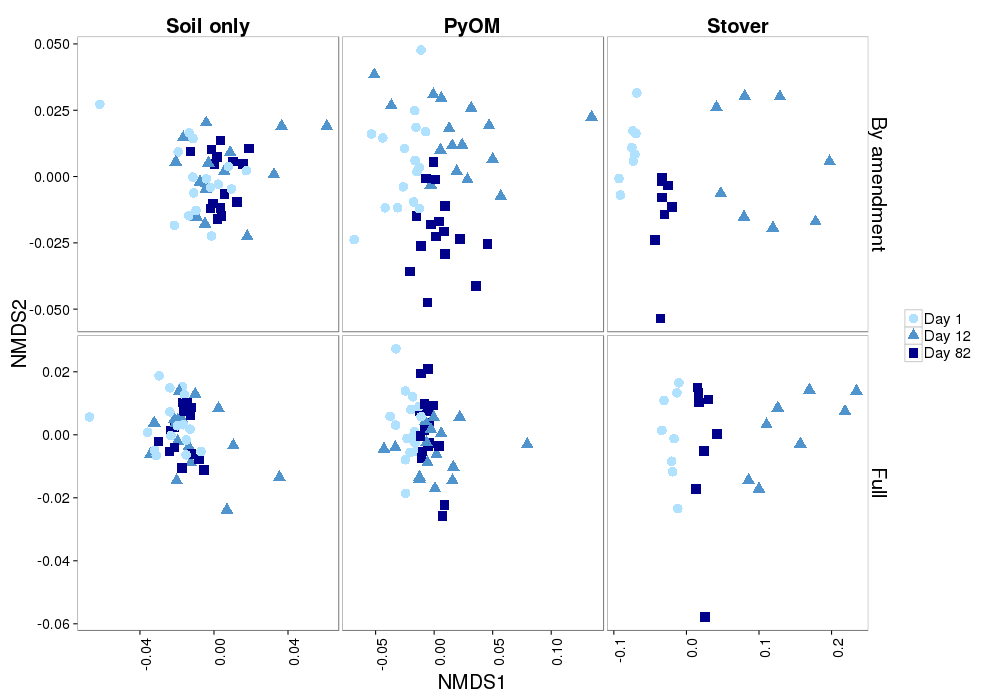

In [21]:
%%R -h 700 -w 1000
D <- NMDS.amdmts
# Sets the relevant ordination

colnames(D)[1:2]<-c("NMDS1","NMDS2")
# Renames the axis columns

D$AmdmtName = ifelse(D$Amdmt==1,"PyOM",ifelse(D$Amdmt==2,"Stover","Soil only"))
D$AmdmtName = factor(D$AmdmtName, levels=c("Soil only", "PyOM", "Stover"))
D$ord = factor(D$ord, levels=c("Full", "By amendment"))
D$DayName = ifelse(D$Day==1,"Day 12",ifelse(D$Day==2,"Day 82","Day 1"))
#D$Strip1 = paste(D$AmdmtName)
D$Strip2 = paste(D$ord)

# Creates an plot object, using the df.sites data, with the x and y axes specified as the PCoA axes,
p = ggplot(D, aes(x = NMDS1, y = NMDS2, color = DayName, shape = DayName))

# Determines the size of the symbols
p = p  + geom_point(size=4.5) + scale_colour_manual(values=c("lightskyblue1","steelblue3","blue4"))

p = p + guides(colour = guide_legend(""), shape = guide_legend(""))

# Determines the color theme of the plot overall
p = p + theme_bw() +
  theme(
    plot.background = element_blank()
   ,panel.grid.major = element_blank()
   ,panel.grid.minor = element_blank()
  ) +
  theme(strip.text.x = element_text(size=14, face="bold"),
          strip.background = element_rect(colour="white", fill="white"))

p = p + theme(strip.text.x = element_text(size = 20),
              strip.text.y = element_text(size = 20),
              axis.text.x = element_text(size = 15, angle = 90, hjust = 1, vjust = 1),
              axis.title.x = element_text(size = 20),
              axis.text.y = element_text(size=15),
              axis.title.y = element_text(size = 20),
              legend.title = element_blank(),
              legend.text = element_text(size = 15))

# Displays the plot object
p = p + facet_grid(~Strip2~AmdmtName, scales = "free")
# The axis scales could be all optimized individually
#p = p + facet_wrap(~AmdmtName)
# Adds a "facet_wrap" to it, which means it will plot it separately by whatever we specify - here, Amendments
plot.amdmts = p
p

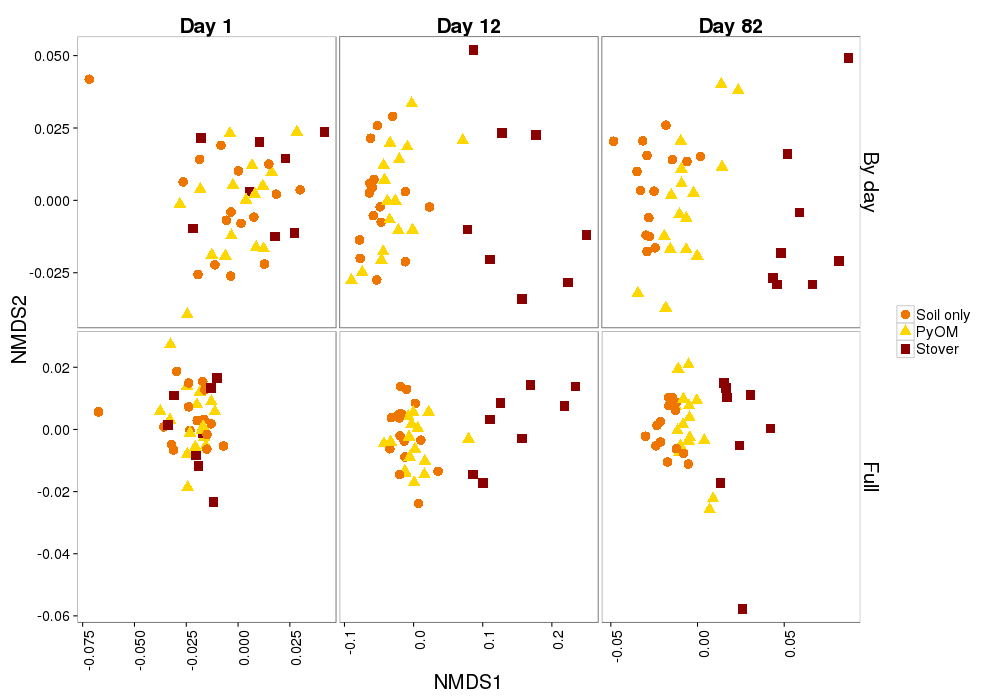

In [34]:
%%R -h 700 -w 1000
D <- NMDS.days
# Sets the relevant ordination

colnames(D)[1:2]<-c("NMDS1","NMDS2")
# Renames the axis columns

D$AmdmtName = ifelse(D$Amdmt==1,"PyOM",ifelse(D$Amdmt==2,"Stover","Soil only"))
D$AmdmtName = factor(D$AmdmtName, levels=c("Soil only", "PyOM", "Stover"))
D$ord = factor(D$ord, levels=c("Full", "By day"))
D$DayName = ifelse(D$Day==1,"Day 12",ifelse(D$Day==2,"Day 82","Day 1"))
D$Strip2 = paste(D$ord)

# Creates an plot object, using the df.sites data, with the x and y axes specified as the PCoA axes,
p = ggplot(D, aes(x = NMDS1, y = NMDS2, color = AmdmtName, shape = AmdmtName))

# Determines the size of the symbols
p = p  + geom_point(size=4.5) + scale_colour_manual(values=c("darkorange2","gold","darkred"))

p = p + guides(colour = guide_legend(""), shape = guide_legend(""))

# Determines the color theme of the plot overall
p = p + theme_bw() +
  theme(
    plot.background = element_blank()
   ,panel.grid.major = element_blank()
   ,panel.grid.minor = element_blank()
  ) +
  theme(strip.text.x = element_text(size=14, face="bold"),
          strip.background = element_rect(colour="white", fill="white"))

p = p + theme(strip.text.x = element_text(size = 20),
              strip.text.y = element_text(size = 20),
              axis.text.x = element_text(size = 15, angle = 90, hjust = 1, vjust = 1),
              axis.title.x = element_text(size = 20),
              axis.text.y = element_text(size=15),
              axis.title.y = element_text(size = 20),
              legend.title = element_blank(),
              legend.text = element_text(size = 15))

# Displays the plot object
p = p + facet_grid(~Strip2~DayName, scales = "free")
# The axis scales could be all optimized individually
# Adds a "facet_wrap" to it, which means it will plot it separately by whatever we specify - here, Amendments
plot.days = p
p

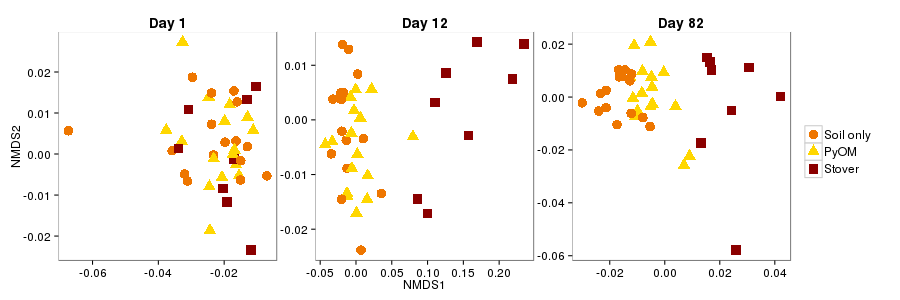

In [53]:
%%R -h 300 -w 900
D <- NMDS.full
# Sets the relevant ordination

colnames(D)[1:2]<-c("NMDS1","NMDS2")
# Renames the axis columns

D$AmdmtName = ifelse(D$Amdmt==1,"PyOM",ifelse(D$Amdmt==2,"Stover","Soil only"))
D$AmdmtName = factor(D$AmdmtName, levels=c("Soil only", "PyOM", "Stover"))
D$DayName = ifelse(D$Day==1,"Day 12",ifelse(D$Day==2,"Day 82","Day 1"))

# Creates an plot object, using the df.sites data, with the x and y axes specified as the PCoA axes,
p = ggplot(D, aes(x = NMDS1, y = NMDS2, color = AmdmtName, shape = AmdmtName))

# Determines the size of the symbols
p = p  + geom_point(size=4.5) + scale_colour_manual(values=c("darkorange2","gold","darkred"))

p = p + guides(colour = guide_legend(""), shape = guide_legend(""))

# Determines the color theme of the plot overall
p = p + theme_bw() +
  theme(
    plot.background = element_blank()
   ,panel.grid.major = element_blank()
   ,panel.grid.minor = element_blank()
  ) +
  theme(strip.text.x = element_text(size=14, face="bold"),axis.text = element_text(size=12),legend.text = element_text(size=12),
          strip.background = element_rect(colour="white", fill="white"))

# Displays the plot object
p = p + facet_wrap(~DayName, scales="free")
# The axis scales could be all optimized individually
#p = p + facet_wrap(~DayName)
# Adds a "facet_wrap" to it, which means it will plot it separately by whatever we specify - here, Days
plot.full.byDay = p
p

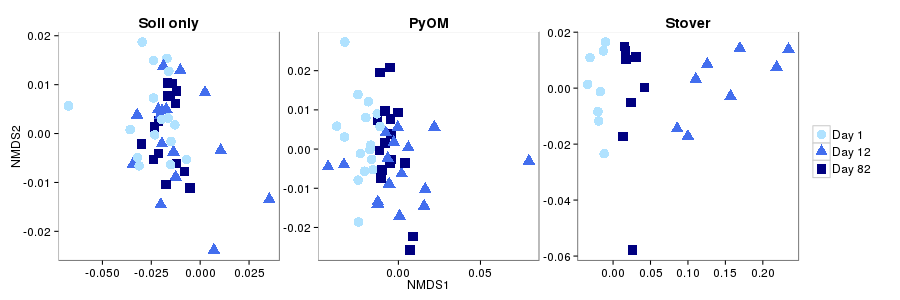

In [38]:
%%R -h 300 -w 900
D <- NMDS.full
# Sets the relevant ordination

colnames(D)[1:2]<-c("NMDS1","NMDS2")
# Renames the axis columns

D$AmdmtName = ifelse(D$Amdmt==1,"PyOM",ifelse(D$Amdmt==2,"Stover","Soil only"))
D$AmdmtName = factor(D$AmdmtName, levels=c("Soil only", "PyOM", "Stover"))
D$DayName = ifelse(D$Day==1,"Day 12",ifelse(D$Day==2,"Day 82","Day 1"))

# Creates an plot object, using the df.sites data, with the x and y axes specified as the PCoA axes,
p = ggplot(D, aes(x = NMDS1, y = NMDS2, color = DayName, shape = DayName))

# Determines the size of the symbols
p = p  + geom_point(size=4.5) + scale_colour_manual(values=c("lightskyblue1","royalblue2","navyblue"))

p = p + guides(colour = guide_legend(""), shape = guide_legend(""))

# Determines the color theme of the plot overall
p = p + theme_bw() +
  theme(
    plot.background = element_blank()
   ,panel.grid.major = element_blank()
   ,panel.grid.minor = element_blank()
  ) +
  theme(strip.text.x = element_text(size=14, face="bold"),axis.text = element_text(size=12),legend.text = element_text(size=12),
          strip.background = element_rect(colour="white", fill="white"))

# Displays the plot object
p = p + facet_wrap(~AmdmtName, scales = "free")
# The axis scales could be all optimized individually
# p = p + facet_wrap(~AmdmtName)
# Adds a "facet_wrap" to it, which means it will plot it separately by whatever we specify - here, Days
plot.full.byAmdmt = p
p

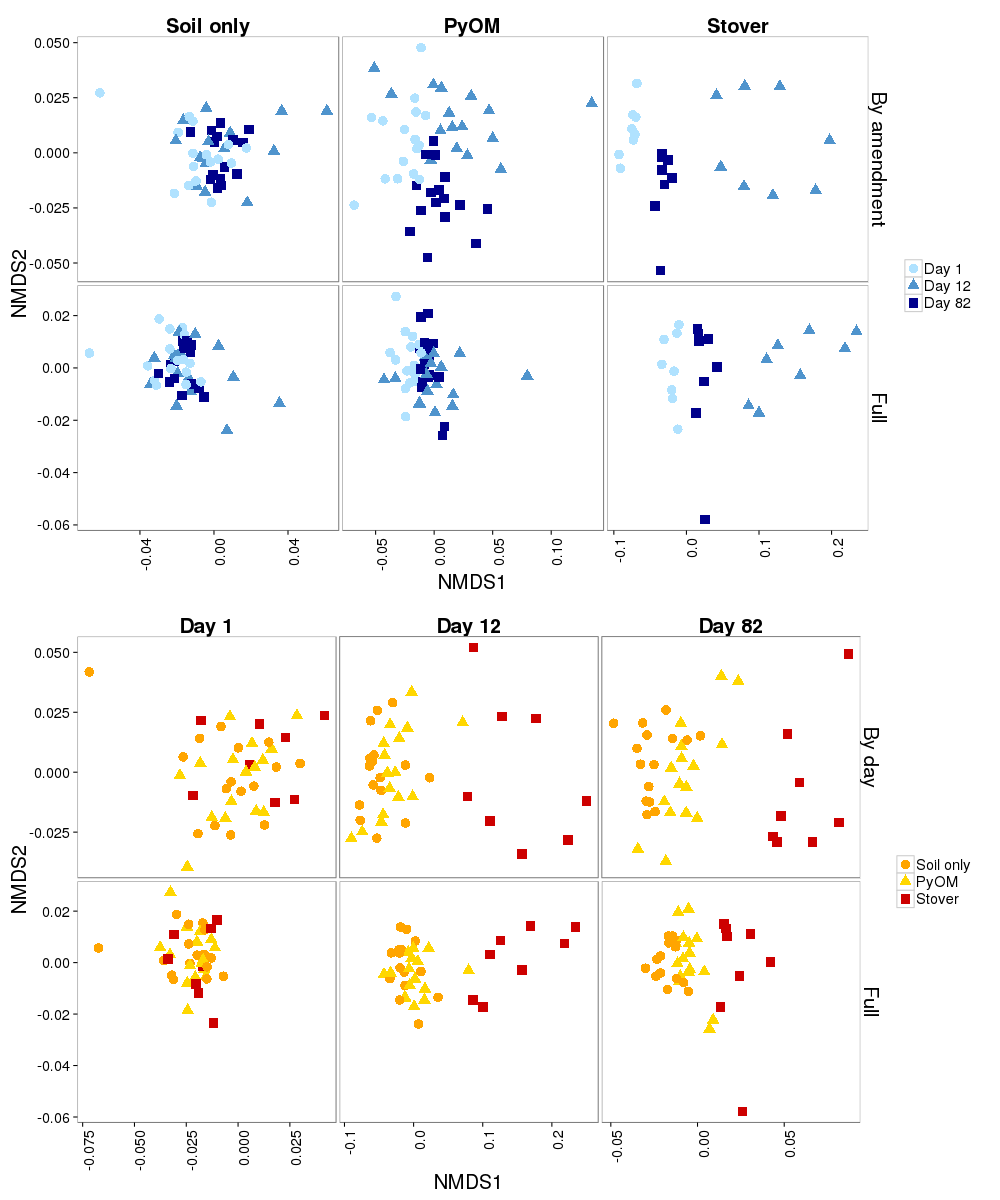

In [25]:
%%R -h 1200 -w 1000
grid.arrange(plot.amdmts, plot.days, nrow=2)

In [50]:
%%R -h 700 -w 1000
p = arrangeGrob(plot.full.byDay, plot.full.byAmdmt, nrow=2)
ggsave(filename = "NMDSDan.pdf", plot = p, width=10, height = 7)
p


Error in ggsave(filename = "NMDSDan.pdf", plot = p, width = 10, height = 7) : 
  plot should be a ggplot2 plot


In [ ]:
%%R -h 700 -w 1000
pdf("NMDSDan.pdf",width=11,height=8) # Open a new pdf file
grid.arrange(plot.full.byDay, plot.full.byAmdmt, nrow=2) # Write the grid.arrange in the file
dev.off()
p = grid.arrange(plot.full.byDay, plot.full.byAmdmt, nrow=2)
p